# Leave One Subject Out Cross Validation (LOSOCV)

In [1]:
import random
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, f1_score, recall_score

/home/stanls/miniconda3/envs/S3S-CNN/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with open('../.data/dataset_128.json') as f:
    dataset = json.load(f)

with open('../MER/mer_config.json', 'r') as f:
    config = json.load(f)

print(config)

In [ ]:
subjects = []
for data in dataset['X']:
    _, __, subject, __ = data[0].split(' ')
    if not subject in subjects:
        subjects.append(subject)

In [ ]:
def generate_losocv_dataset(dataset, subject, visualize=True):
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']

    for x, y in zip(dataset['X'], dataset['y']):
        if subject in x[0]:
            test_X.append(x)
            test_y.append(y)
        else:
            train_X.append(x)   
            train_y.append(y)

    if visualize:
        train_set = []
        test_set = []
        for i, emo in enumerate(emotions):
            train_set.append(train_y.count(i))
            test_set.append(test_y.count(i))

        df = pd.DataFrame({
            'train': train_set,
            'test': test_set
        }, index=emotions)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax = df.plot.bar(rot=0, ax=ax)
        for container in ax.containers:
            ax.bar_label(container)

        ax.set_title('Data Distribution')
        plt.show()

    return train_X, train_y, test_X, test_y

def generate_dataloader(X, y, batch_size):
    X_data = []
    y_data = []

    g = torch.Generator()
    g.manual_seed(0)

    for (of, ops, h, v), y in zip(X, y):
        of = cv2.imread(of, cv2.IMREAD_GRAYSCALE)
        ops = cv2.imread(ops, cv2.IMREAD_GRAYSCALE)
        h = cv2.imread(h, cv2.IMREAD_GRAYSCALE)
        v = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
        img = np.array([ops, h, v])

        X_data.append(img)
        y_data.append(y)

    X_tensor = torch.Tensor(np.array(X_data))
    y_tensor = torch.Tensor(y_data).to(dtype=torch.long)

    tensor_dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(tensor_dataset, 
                            batch_size=batch_size, 
                            shuffle=True,
                            generator=g)

    return data_loader

In [ ]:
class MER(nn.Module):
    def __init__(self, in_channels=1, num_classes=6):
        super(MER, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d
        self.fc = nn.Linear(in_features=24 * 16 * 16, out_features=num_classes)

        self.conv_layer1 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer2 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer3 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )
    
    def forward(self, x):
        ops, h, v = x
        x1 = self.conv_layer1(ops)
        x2 = self.conv_layer2(h)
        x3 = self.conv_layer3(v)

        x = torch.cat((x1, x2, x3), dim=1)
        x_avg = self.avg_pool(x)
        # print(x_avg.shape)

        # fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(16, 8))
        # ax[0, 0].imshow(ops[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[0, 1].imshow(h[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[0, 2].imshow(v[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[1, 0].imshow(x1[0, 1, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[1, 1].imshow(x2[0, 1, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[1, 2].imshow(x3[0, 1, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[2, 0].imshow(x[0, 1, :, :].cpu().detach().numpy(), cmap='gray')
        # ax[2, 1].imshow(x_avg[0, 1, :, :].cpu().detach().numpy(), cmap='gray')
        # plt.show()

        x_avg = x_avg.view(x_avg.size(0), -1)
        x_fc = self.fc(x_avg)

        return x_fc

In [ ]:
model = MER()
num_of_parameters = sum(map(torch.numel, model.parameters()))
print(f'Number of parameters: {num_of_parameters/1000000} million')

In [ ]:
print(config)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

print('== Training LOSOCV ==')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']

actual = []
predicted = []
uf1_history = []
uar_history = []
accuracy_history = []
num_correct = 0
total_sample = 0

cm_df = None
# subjects = [subject for subject in subjects if 'c_' in subject]

for i, subject in enumerate(subjects):
    print(f'Subject ({i+1}/{len(subjects)}): {subject}')

    train_X, train_y, test_X, test_y = generate_losocv_dataset(dataset, subject, visualize=False)
    train_loader = generate_dataloader(train_X, train_y, batch_size=config['batch_size'])
    test_loader = generate_dataloader(test_X, test_y, batch_size=config['batch_size'])

    model = MER().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    epochs = config['epoch']

    # TRAINING
    model.train()
    for epoch in range(epochs):
        for batch, y in train_loader:
            batch = batch.to(device)
            y = y.to(device)

            ops = batch[:, :1, :, :]
            h = batch[:, 1:2, :, :]
            v = batch[:, 2:, :, :]

            optimizer.zero_grad()
            y_hat = model.forward((ops, h, v))
            loss = criterion(y_hat, y)

            loss.backward()
            optimizer.step()

    # TESTING
    model.eval()
    with torch.no_grad():
        y_preds = torch.Tensor().to(device)
        y_test = torch.Tensor().to(device)

        for batch, y in test_loader:
            batch = batch.to(device)
            y = y.to(device)

            ops = batch[:, :1, :, :]
            h = batch[:, 1:2, :, :]
            v = batch[:, 2:, :, :]

            y_hat = model.forward((ops, h, v))
            y_hat = torch.argmax(y_hat, dim=1)
            y_preds = torch.cat((y_preds, y_hat), dim=0)
            y_test = torch.cat((y_test, y), dim=0)
        
        y_test = y_test.to('cpu')
        y_preds = y_preds.to('cpu')
        print(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}')
        print(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}')

        cm = confusion_matrix(y_test, y_preds, labels=range(6))
        if type(cm_df) != pd.DataFrame:
            cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
        else:
            cm_df = cm_df.add(pd.DataFrame(cm, index=emotions, columns=emotions))

        uf1 = f1_score(y_test, y_preds, average='macro')
        uar = recall_score(y_test, y_preds, average='macro', zero_division=0)

        print(f'UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
        
        num_correct += (y_preds == y_test).sum().item()
        total_sample += len(y_test)
        accuracy = num_correct / total_sample
        accuracy_history.append(accuracy)

        actual.extend(y_test.tolist())
        predicted.extend(y_preds.tolist())
        uf1 = f1_score(actual, predicted, average='macro')
        uar = recall_score(actual, predicted, average='macro', zero_division=0)
        uf1_history.append(uf1)
        uar_history.append(uar)

        print(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
        print('=========================================================')

print(f'Final Accuracy: {accuracy_history[-1]:.4f}')
print(f'Final UF1 score: {uf1_history[-1]:.4f}')
print(f'Final UAR score: {uar_history[-1]:.4f}')

# SCRATCH

In [4]:
import cv2
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

/home/stanls/miniconda3/envs/MER/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def read_file(file_name):
    with open(file_name) as f:
        data = json.load(f)
    return data

In [6]:
def generate_losocv_dataset(dataset, subject, visualize=True):
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']

    for x, y in zip(dataset['X'], dataset['y']):
        if subject in x[0]:
            test_X.append(x)
            test_y.append(y)
        else:
            train_X.append(x)   
            train_y.append(y)

    if visualize:
        train_set = []
        test_set = []
        for i, emo in enumerate(emotions):
            train_set.append(train_y.count(i))
            test_set.append(test_y.count(i))

        df = pd.DataFrame({
            'train': train_set,
            'test': test_set
        }, index=emotions)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax = df.plot.bar(rot=0, ax=ax)
        for container in ax.containers:
            ax.bar_label(container)

        ax.set_title('Data Distribution')
        plt.show()

    return train_X, train_y, test_X, test_y

def generate_dataloader(X, y, batch_size):
    X_data = []
    y_data = []

    g = torch.Generator()
    g.manual_seed(0)

    for (of, ops, h, v), y in zip(X, y):
        of = cv2.imread(of, cv2.IMREAD_GRAYSCALE)
        ops = cv2.imread(ops, cv2.IMREAD_GRAYSCALE)
        h = cv2.imread(h, cv2.IMREAD_GRAYSCALE)
        v = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
        img = np.array([ops, h, v])

        X_data.append(img)
        y_data.append(y)

    X_tensor = torch.Tensor(np.array(X_data))
    y_tensor = torch.Tensor(y_data).to(dtype=torch.long)

    tensor_dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(tensor_dataset, 
                            batch_size=batch_size, 
                            shuffle=True,
                            generator=g)

    return data_loader

def get_subjects(dataset):
    subjects = []
    for data in dataset['X']:
        _, __, subject, __ = data[0].split(' ')
        if not subject in subjects:
            subjects.append(subject)
    
    return subjects

In [7]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

config = {
    "lr": 0.001,
    "batch_size": 128,
    "epoch": 30,
    "img_dim": 128
}
dataset = read_file(f'../.data/dataset_{config["img_dim"]}.json')
print(config)

{'lr': 0.001, 'batch_size': 128, 'epoch': 30, 'img_dim': 128}


In [58]:
class MER(nn.Module):
    def __init__(self, in_channels=1, num_classes=6):
        super(MER, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d
        self.fc = nn.Linear(in_features=24 * 16 * 16, out_features=num_classes)

        self.conv_layer1 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer2 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer3 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )
    
    def forward(self, x, visualize=False):
        ops, h, v = x
        x1 = self.conv_layer1(ops)
        x2 = self.conv_layer2(h)
        x3 = self.conv_layer3(v)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.avg_pool(x)

        fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
        ax[0].imshow(ops[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
        ax[1].imshow(h[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
        ax[2].imshow(v[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
        ax[3].imshow(x[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
        if visualize:
            plt.show()
        
        plt.close(fig)

        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [59]:
def compute_f1_recall(real, pred):
    TN, FP, FN, TP = confusion_matrix(real, pred).ravel()
    if 2 * TP + FP + FN == 0:
        f1_score = 0
    else:
        f1_score = 2 * TP / (2 * TP + FP + FN)

    if real.count(1) == 0:
        recall = 0
    else:
        recall = TP / real.count(1)
    
    return f1_score, recall

def evaluation_metrics(real, pred, emotions):
    f1_list = []
    recall_list = []
    for i, emotion in enumerate(emotions):
        y_real = [1 if i == j else 0 for j in real]
        y_pred = [1 if i == j else 0 for j in pred]

        try:
            f1, recall = compute_f1_recall(y_real, y_pred)
            f1_list.append(f1)
            recall_list.append(recall)
        except Exception:
            pass
    
    uf1 = np.mean(f1_list)
    uar = np.mean(recall_list)

    return uf1, uar

In [63]:
def train_locosv():
    print('== Training LOSOCV ==')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    emotions = ['anger', 'sadness', 'surprise', 'fear', 'happiness', 'disgust']

    actual = []
    predicted = []
    uf1_history = []
    uar_history = []
    accuracy_history = []
    num_correct = 0
    total_sample = 0

    cm_df = None

    subjects = get_subjects(dataset)
    # subjects = [subject for subject in subjects if 'c_' in subject]

    for i, subject in enumerate(subjects):
        print(f'Subject ({i+1}/{len(subjects)}): {subject}')

        train_X, train_y, test_X, test_y = generate_losocv_dataset(dataset, subject, visualize=False)
        train_loader = generate_dataloader(train_X, train_y, batch_size=config['batch_size'])
        test_loader = generate_dataloader(test_X, test_y, batch_size=config['batch_size'])

        model = MER().to(device)
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        criterion = nn.CrossEntropyLoss()

        epochs = config['epoch']

        # TRAINING
        model.train()
        for epoch in range(epochs):
            for batch, y in train_loader:
                batch = batch.to(device)
                y = y.to(device)

                ops = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                optimizer.zero_grad()
                y_hat = model.forward((ops, h, v))
                loss = criterion(y_hat, y)

                loss.backward()
                optimizer.step()

        # TESTING
        model.eval()
        with torch.no_grad():
            y_preds = torch.Tensor().to(device)
            y_test = torch.Tensor().to(device)

            for batch, y in test_loader:
                batch = batch.to(device)
                y = y.to(device)

                ops = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                y_hat = model.forward((ops, h, v))
                y_hat = torch.argmax(y_hat, dim=1)
                y_preds = torch.cat((y_preds, y_hat), dim=0)
                y_test = torch.cat((y_test, y), dim=0)
            
            y_test = y_test.to('cpu')
            y_preds = y_preds.to('cpu')
            print(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}')
            print(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}')

            cm = confusion_matrix(y_test, y_preds, labels=range(6))
            if type(cm_df) != pd.DataFrame:
                cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
            else:
                cm_df = cm_df.add(pd.DataFrame(cm, index=emotions, columns=emotions))
            
            num_correct += (y_preds == y_test).sum().item()
            total_sample += len(y_test)
            accuracy = num_correct / total_sample
            accuracy_history.append(accuracy)

            actual.extend(y_test.tolist())
            predicted.extend(y_preds.tolist())

            uf1, uar = evaluation_metrics(actual, predicted, emotions)
            uf1_history.append(uf1)
            uar_history.append(uar)

            print(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
            print('=========================================================')


    # uf1, uar = evaluation_metrics(actual, predicted, emotions) 

    # print(f'Final Accuracy: {accuracy_history[-1]:.4f}')
    # print(f'Final UF1 score: {uf1:.4f}')
    # print(f'Final UAR score: {uar:.4f}')

In [64]:
model = MER()
num_of_parameters = sum(map(torch.numel, model.parameters()))
print(f'Number of parameters: {num_of_parameters/1000000} million')

Number of parameters: 0.036998 million


## Training

== Training LOSOCV ==
Subject (1/80): m_13


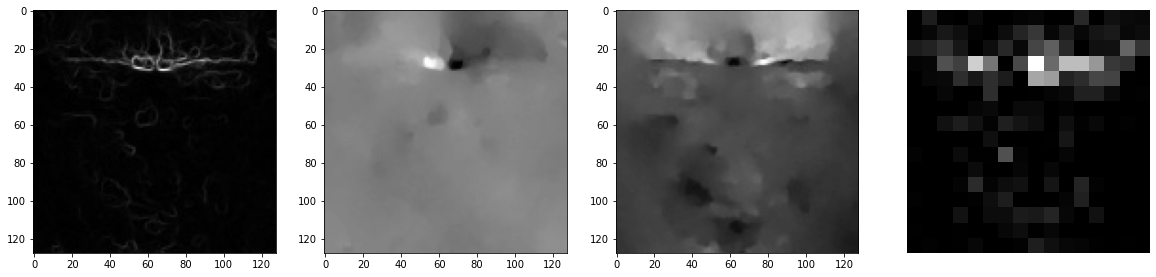

In [62]:
train_locosv()